# Chapter 14: Revisiting Vienna

For additional context see chapter 14 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [93]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr

%matplotlib inline

## Get the data

In [86]:
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

In [87]:
# Establish the dataset_url
rate_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/impact-of-handwashing-death-to-birth-rates.csv'

# Get data
rate_df = get_data(rate_url)

# Drop unnecessary columns
rate_df = rate_df.drop(['Hospital', 'Month', 'Year', 'Births', 'Deaths'], axis=1)

# Specify 'Year' column dtype as string
rate_df['MonthYear'] = rate_df['MonthYear'].astype('string')

# Calculate the moving range
rate_df['Moving Range'] = abs(rate_df['Rate'].diff())

# Show dataframe
rate_df.head()
rate_df['Stage'].unique()
rate_df

,Stage,MonthYear,Rate,Moving Range
0,Before handwashing,Jan-41,14.6,NaN
1,Before handwashing,Feb-41,7.5,7.1
2,Before handwashing,Mar-41,4.3,3.2
3,Before handwashing,Apr-41,1.6,2.7
4,Before handwashing,May-41,0.8,0.8
...,...,...,...,...
94,After handwashing,Nov-48,2.9,0.6
95,After handwashing,Dec-48,1.3,1.6
96,After handwashing,Jan-49,2.2,0.9
97,After handwashing,Feb-49,3.1,0.9


In [88]:
# Split dataframe into before and after handwashing
before_df = rate_df[rate_df['Stage'] == 'Before handwashing']

# After dataframe
after_df = rate_df[rate_df['Stage'] == 'After handwashing'].drop(columns='Moving Range').reset_index(drop=True)

# # Recaclulate 'Moving Ranges'
after_df['Moving Range'] = abs(after_df['Rate'].diff())
after_df

,Stage,MonthYear,Rate,Moving Range
0,After handwashing,Jun-47,2.2,NaN
1,After handwashing,Jul-47,1.2,1.0
2,After handwashing,Aug-47,1.9,0.7
3,After handwashing,Sep-47,4.6,2.7
4,After handwashing,Oct-47,4.0,0.6
5,After handwashing,Nov-47,4.5,0.5
6,After handwashing,Dec-47,2.9,1.6
7,After handwashing,Jan-48,3.5,0.6
8,After handwashing,Feb-48,0.7,2.8
9,After handwashing,Mar-48,0.0,0.7


## Figure 14.1: XmR chart of death-to-birth rates

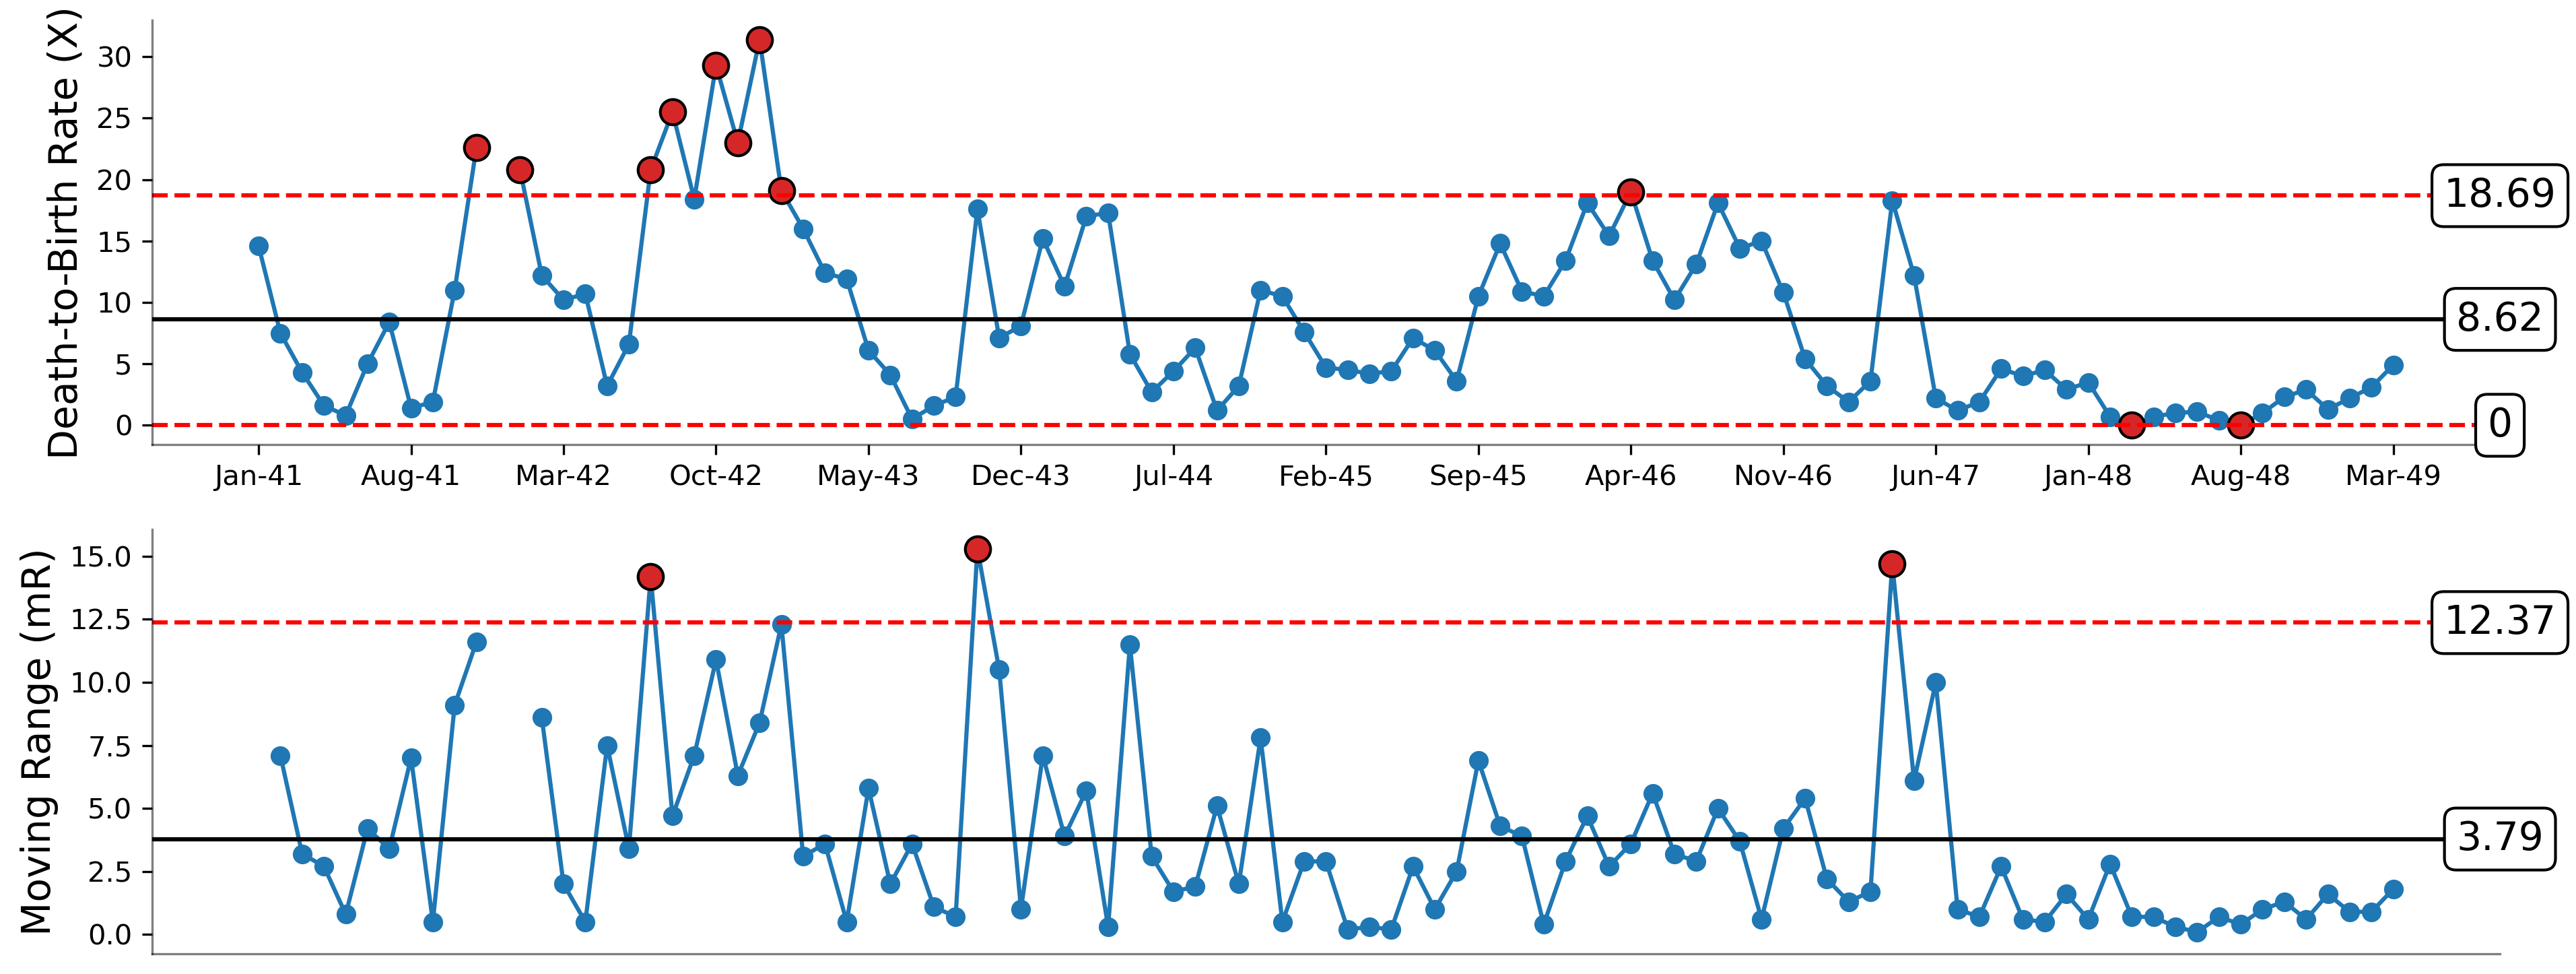

In [92]:
# Round setting
round_value = 2

# Extract Data
data = rate_df['Rate']
labels = rate_df['MonthYear']
moving_ranges = rate_df['Moving Range']

# Calculate statistics
mean = data.mean()
average_mR = moving_ranges.mean()

# Calculate the process limits
C1 = 2.660
C2 = 3.268

UPL = round(mean + (C1*average_mR),round_value)
LPL = max(0,round(mean - (C1*average_mR),round_value))
URL = round((C2*average_mR),round_value)

# Define Process Limits
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR, '-', 'black'), (URL, '--', 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1, dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, linestyle, color in xchart_lines:
    axs[0].axhline(value, ls=linestyle, c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value, round_value), fontsize=14,
                color='black', ha='center', va='center', bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Optional: highlight missing points
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add Process Limits
for value, linestyle, color in mrchart_lines:
    axs[1].axhline(value, ls=linestyle, c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1] * 1.0, value, round(value, round_value), fontsize=14,
                color='black', ha='center', va='center', bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Death-to-Birth Rate (X)", fontsize=14)
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Show Plot
plt.show()

## Figure 14.2: Annotated XmR chart of death-to-birth rates

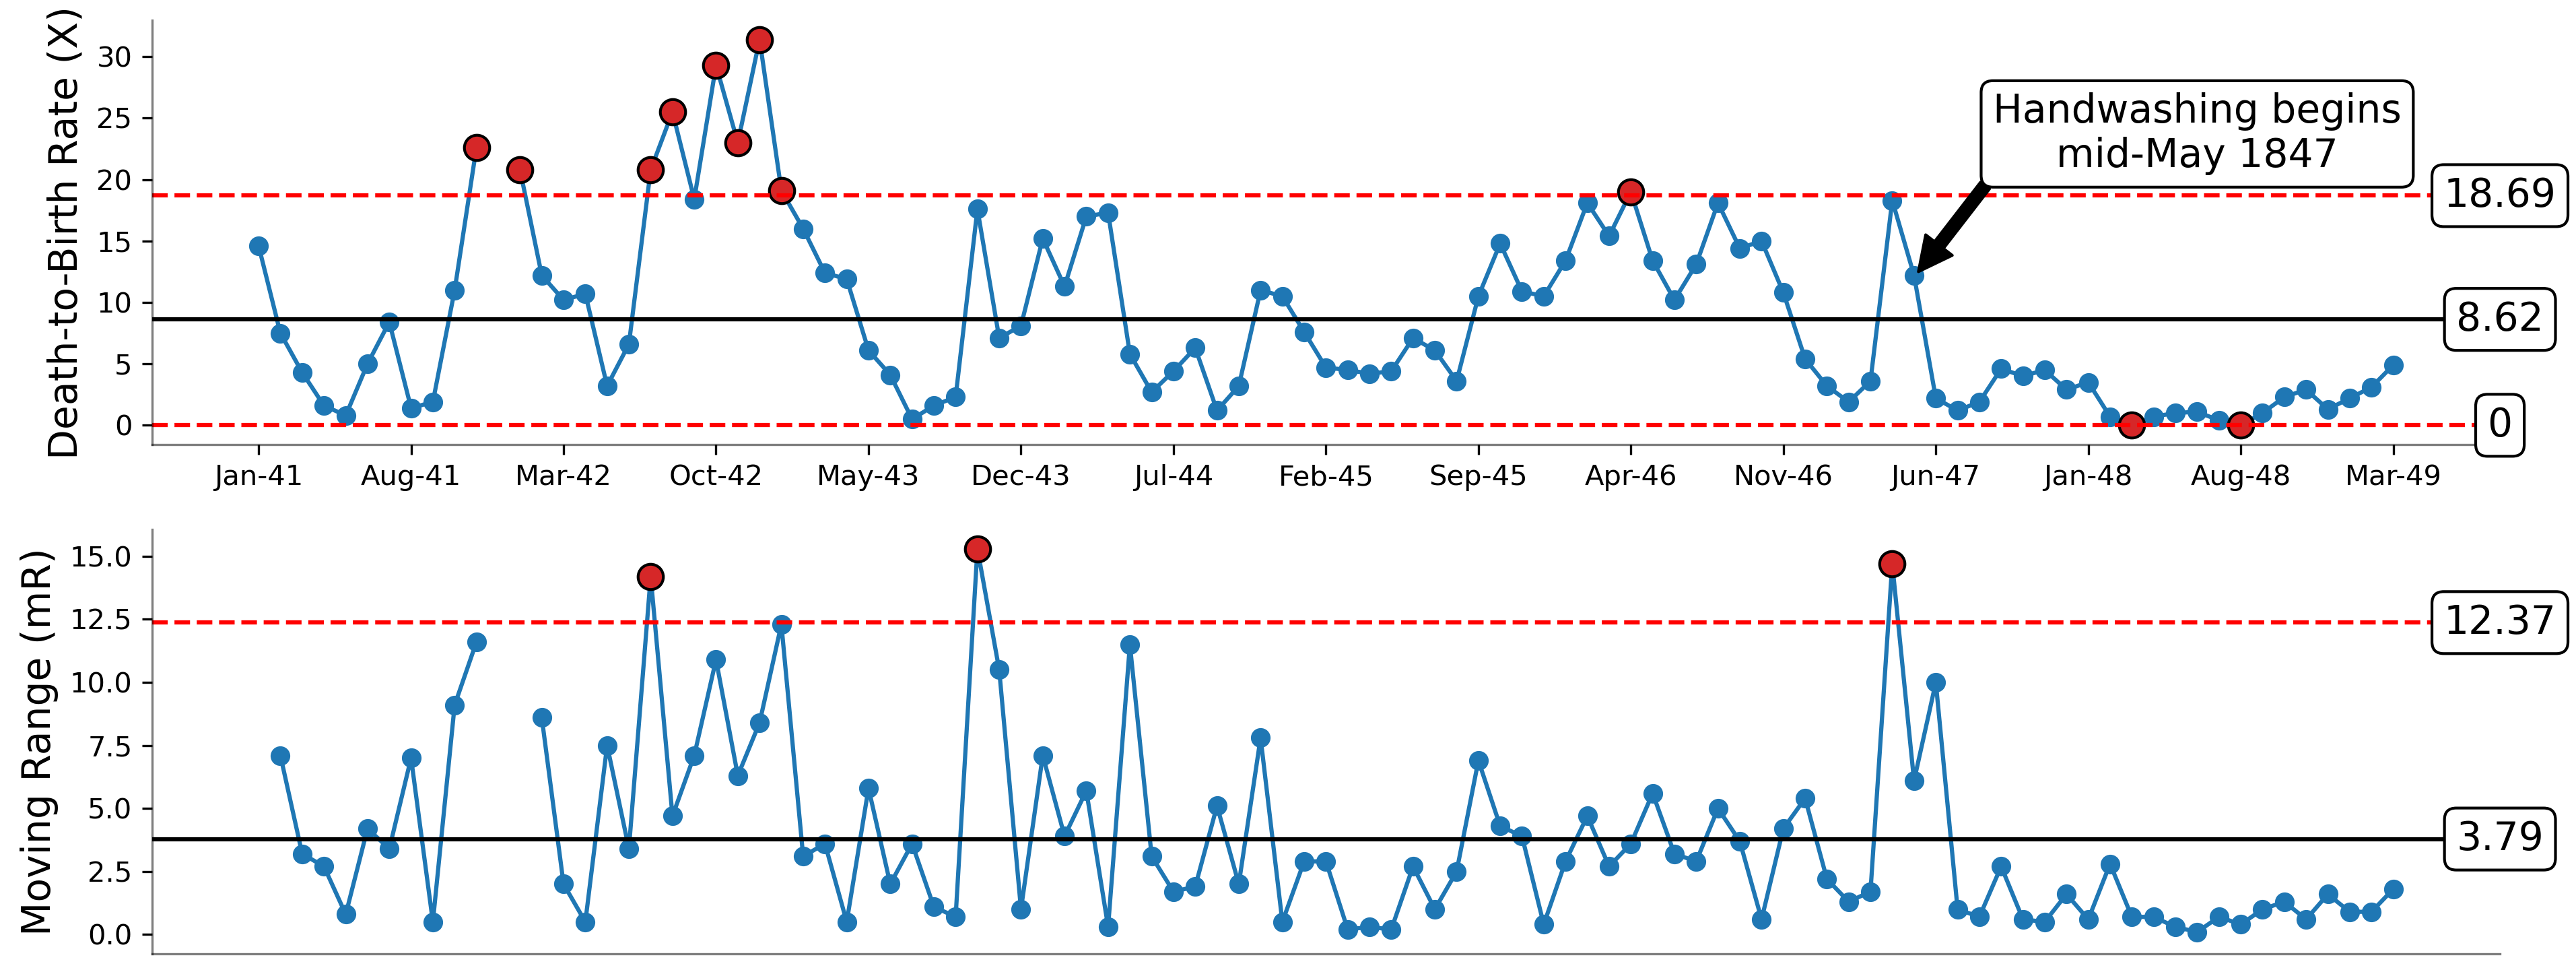

In [74]:
# Round setting
round_value = 2

# Extract Data
data = rate_df['Rate']
labels = rate_df['MonthYear']
moving_ranges = rate_df['Moving Range']

# Calculate statistics
mean = data.mean()
average_mR = moving_ranges.mean()

# Calculate the process limits
C1 = 2.660
C2 = 3.268

UPL = round(mean + (C1*average_mR),round_value)
LPL = max(0,round(mean - (C1*average_mR),round_value))
URL = round((C2*average_mR),round_value)

# Define Process Limits
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR, '-', 'black'), (URL, '--', 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1, dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, linestyle, color in xchart_lines:
    axs[0].axhline(value, ls=linestyle, c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value, round_value), fontsize=14,
                color='black', ha='center', va='center', bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Optional: highlight missing points
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

# Add Process Limits
for value, linestyle, color in mrchart_lines:
    axs[1].axhline(value, ls=linestyle, c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1] * 1.0, value, round(value, round_value), fontsize=14,
                color='black', ha='center', va='center', bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Death-to-Birth Rate (X)", fontsize=14)
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)", fontsize=14)

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Add arrow to highlight May-1847
axs[0].annotate('Handwashing begins\nmid-May 1847', 
             xy=(76.2,12.5), 
             xytext=(89,21), 
             color='black', 
             fontsize=14,
             ha='center',
             arrowprops=dict(facecolor='black'),
             bbox=dict(facecolor='white',boxstyle='round',edgecolor='black'))

# Show Plot
plt.show()

## Figure 14.3: Comparison chart of before and after handwashing

In [69]:
# Create list of before and after dataframres
df_list = [before_df, after_df]

# Create list of comparison plot titles
plot_label_names = ['Before handwashing', 'After handwashing']

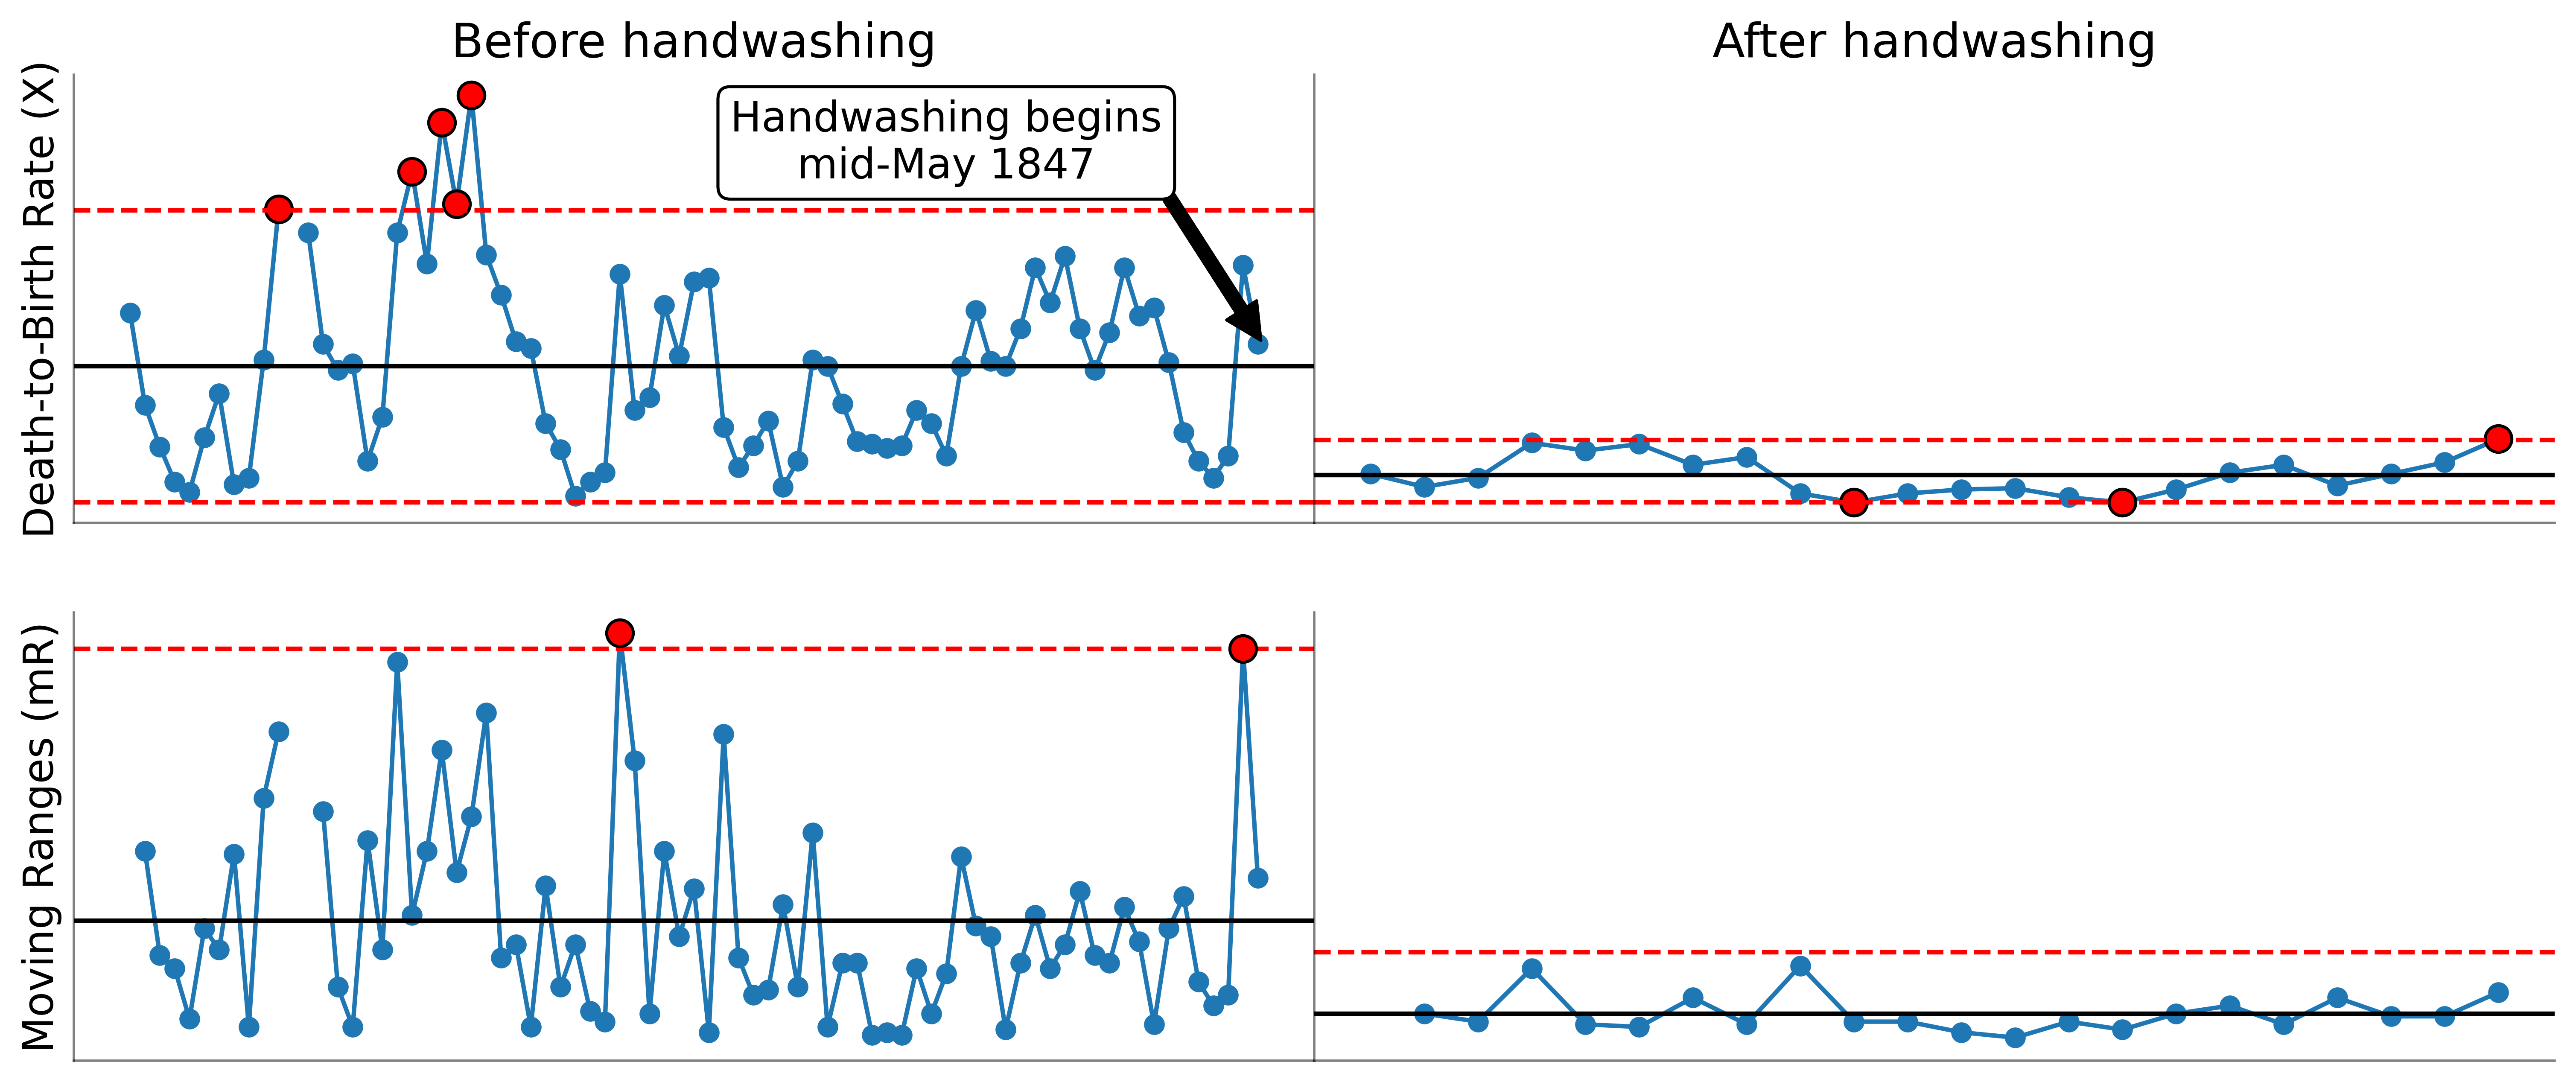

In [82]:
# Specify round_value
round_value = 1
# Specify tick interval
tickinterval = 5

show_limit_labels=False

# Specify condition
condition = 'Rate'
xtick_labels = 'MonthYear'

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, plot_label_names)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value)
    xticks = df[xtick_labels]

    # Specify scaling factors
    C1 = 2.660
    C2 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (C1 * average_mR), round_value)
    LPL = round(max(mean - (C1 * average_mR), 0), round_value)
    URL = round(C2 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })

    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label, fontsize=16)
    
        # Add arrow to highlight May-1847
    axes[0, 0].annotate('Handwashing begins\nmid-May 1847', 
                 xy=(76.2,12.5), 
#                  xytext=(89,21),
                 xytext=(55, 25),
                 color='black', 
                 fontsize=14,
                 ha='center',
                 arrowprops=dict(facecolor='black'),
                 bbox=dict(facecolor='white',boxstyle='round',edgecolor='black'))

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='red', linestyle='--')
    axes[0, idx].axhline(LPL, color='red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='-')
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), tickinterval)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center')

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')
    
    # Offset moving range by 1 relative to the individual values
    for xi, yi in zip(labels, moving_ranges):
        if np.isnan(yi):
            axes[1, idx].plot(xi, 0, marker='x', color='white', markersize=0)

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='-')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Death-to-Birth Rate (X)', fontsize=14)
    axes[1, 0].set_ylabel('Moving Ranges (mR)', fontsize=14)
    
    # Remove yticks
    axes[0, 0].set_yticks([])
    axes[1, 0].set_yticks([])
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
    
    if show_limit_labels:
        # Add labels to 2nd and 4th plots
        if idx == 1:
            axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', bbox=bbox_props)
            axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', bbox=bbox_props)
            axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center', bbox=bbox_props)

        if idx == 1:
            axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', bbox=bbox_props)
            axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                              color='black', ha='center', va='center', bbox=bbox_props)

    # Remove ticks on xticks for moving ranges
    axes[0, idx].set_xticks([])
    axes[1, idx].set_xticks([])
    
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)
                
# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
stats_df = pd.DataFrame(stats_list)

## Figure 14.4: XmR chart for after handwashing system

In [94]:
# Specify tickinterval
tickinterval = 2
round_value = 2
# Disaggregate the dataframe 
data = after_df["Rate"]
moving_ranges = after_df['Moving Range']
labels = after_df["MonthYear"]

C1 = 2.660
C2 = 3.268

mean = round(data.mean(),round_value)
average_mR = moving_ranges.mean()

UPL = round(mean + (C1*average_mR),round_value)
UPL = 4.82
LPL = max(0,mean - (C1*average_mR))
URL = round(C2*average_mR, round_value)
URL=3.33

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-','black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR, '-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

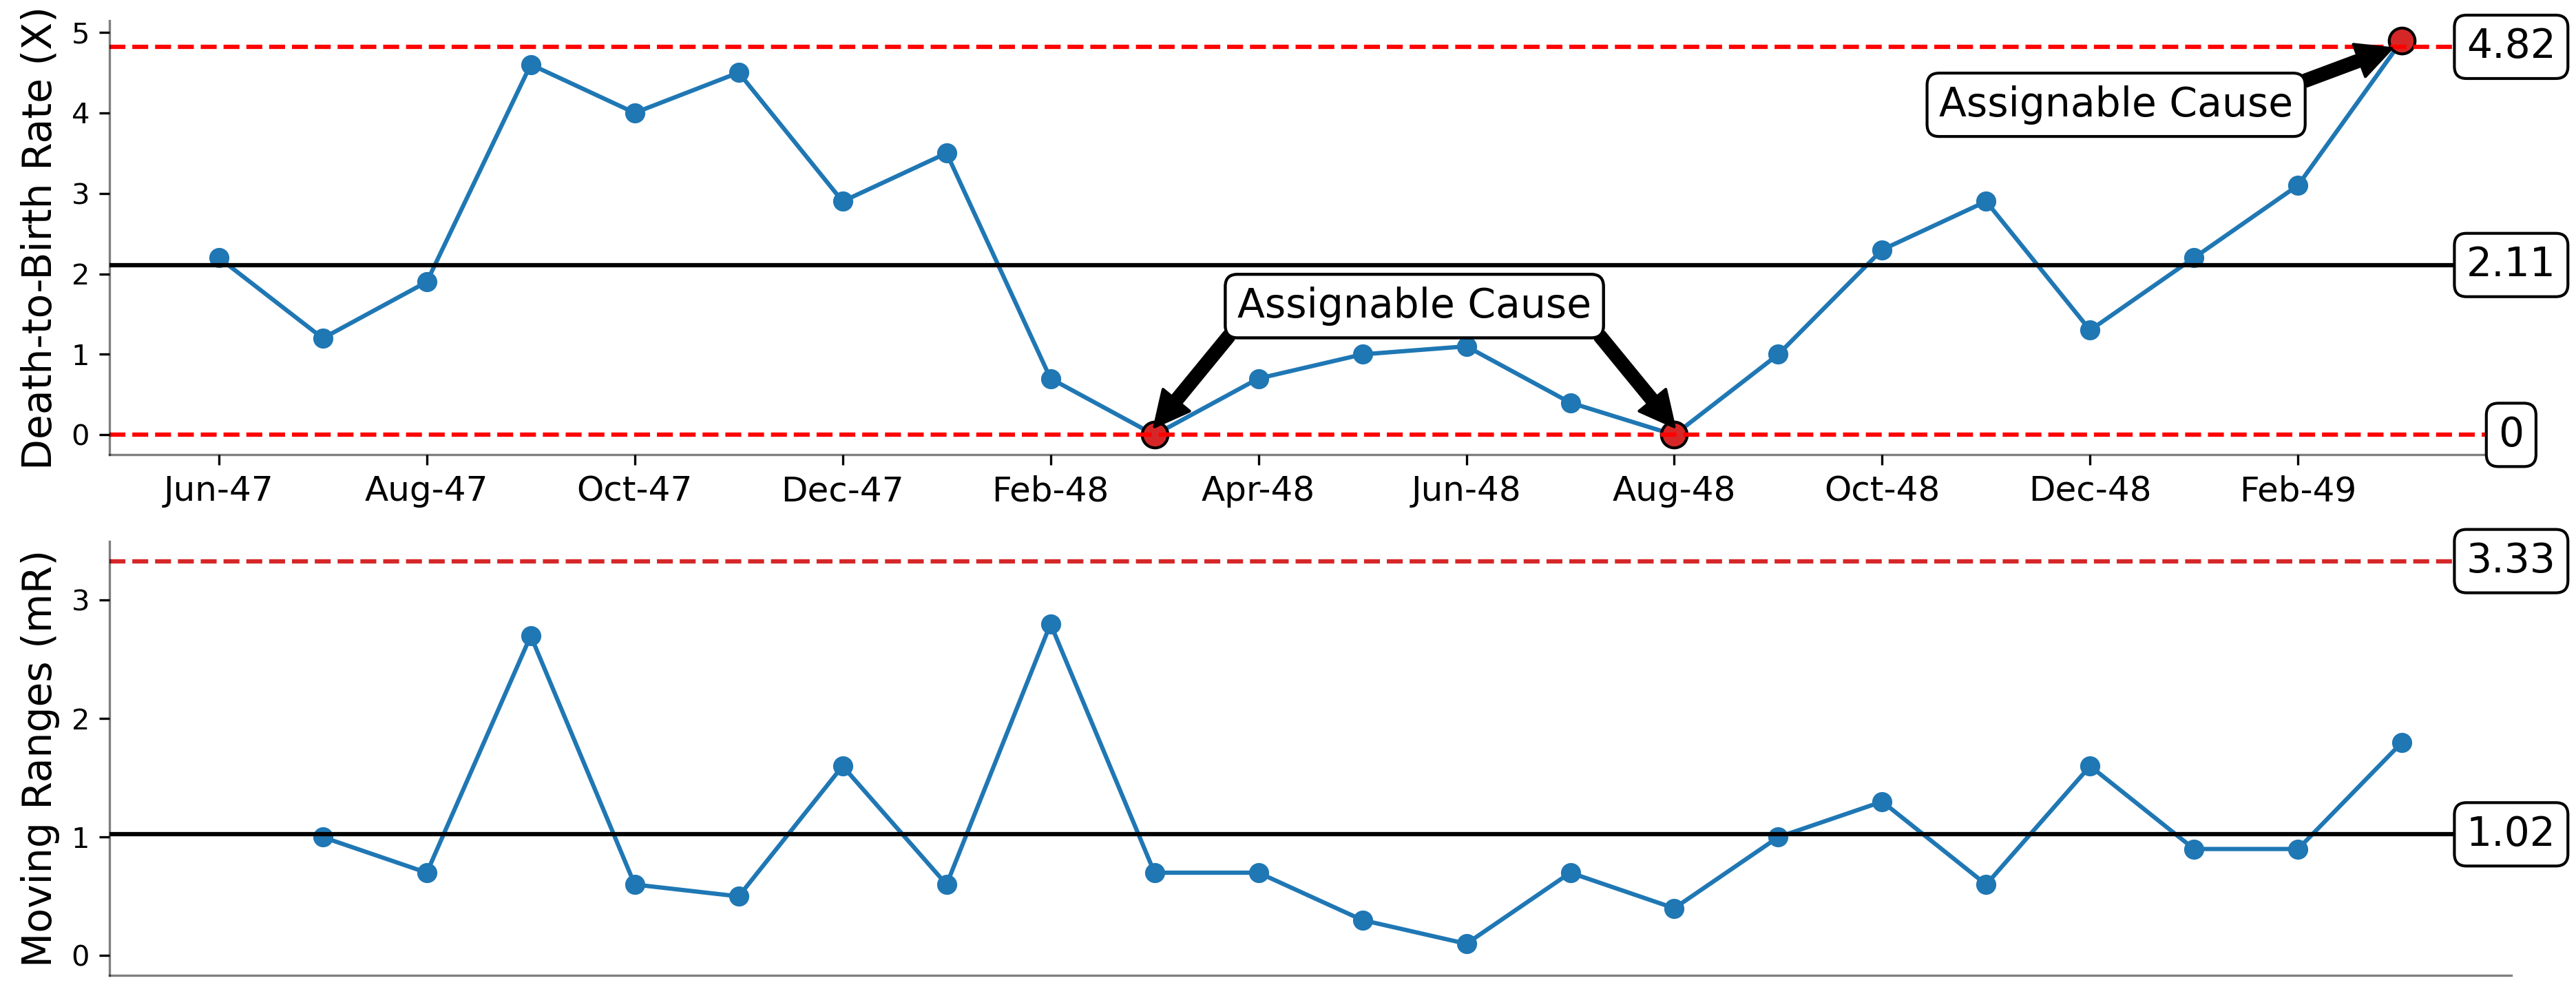

In [95]:
# Generate the X-chart
fig, axs = plt.subplots(figsize=(15,6), nrows=2, ncols=1, dpi=300)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, UPL, color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, LPL, color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, mean, color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linestyle, color in xchart_lines:
    axs[0].axhline(value, ls=linestyle, c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center',
                      fontsize=12) 

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Death-to-Birth Rate (X)", fontsize=14)
axs[0].set_title("", fontsize=14)

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Assignable Cause', (9,0.1),(11.5,1.6)),
    ('Assignable Cause', (14,0.1),(11.5,1.6)),
    ('Assignable Cause', (20.9, 4.8),(18.25, 4.1))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')
# Optional: highlight missing points
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

axs[1].axhline(URL, ls='--', c='tab:red')
axs[1].axhline(average_mR, ls='-', c='black')

axs[1].text(axs[1].get_xlim()[1], URL, round(URL,round_value), color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], average_mR, round(average_mR,round_value), color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

# Remove xticks on mR chart
axs[1].set_xticks([])
axs[1].set_ylabel('Moving Ranges (mR)', fontsize=14,)

# Despine 
sns.despine()
for value in range(0,2):
    axs[value].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Figure 14.5: Annotated XmR chart of after handwashing

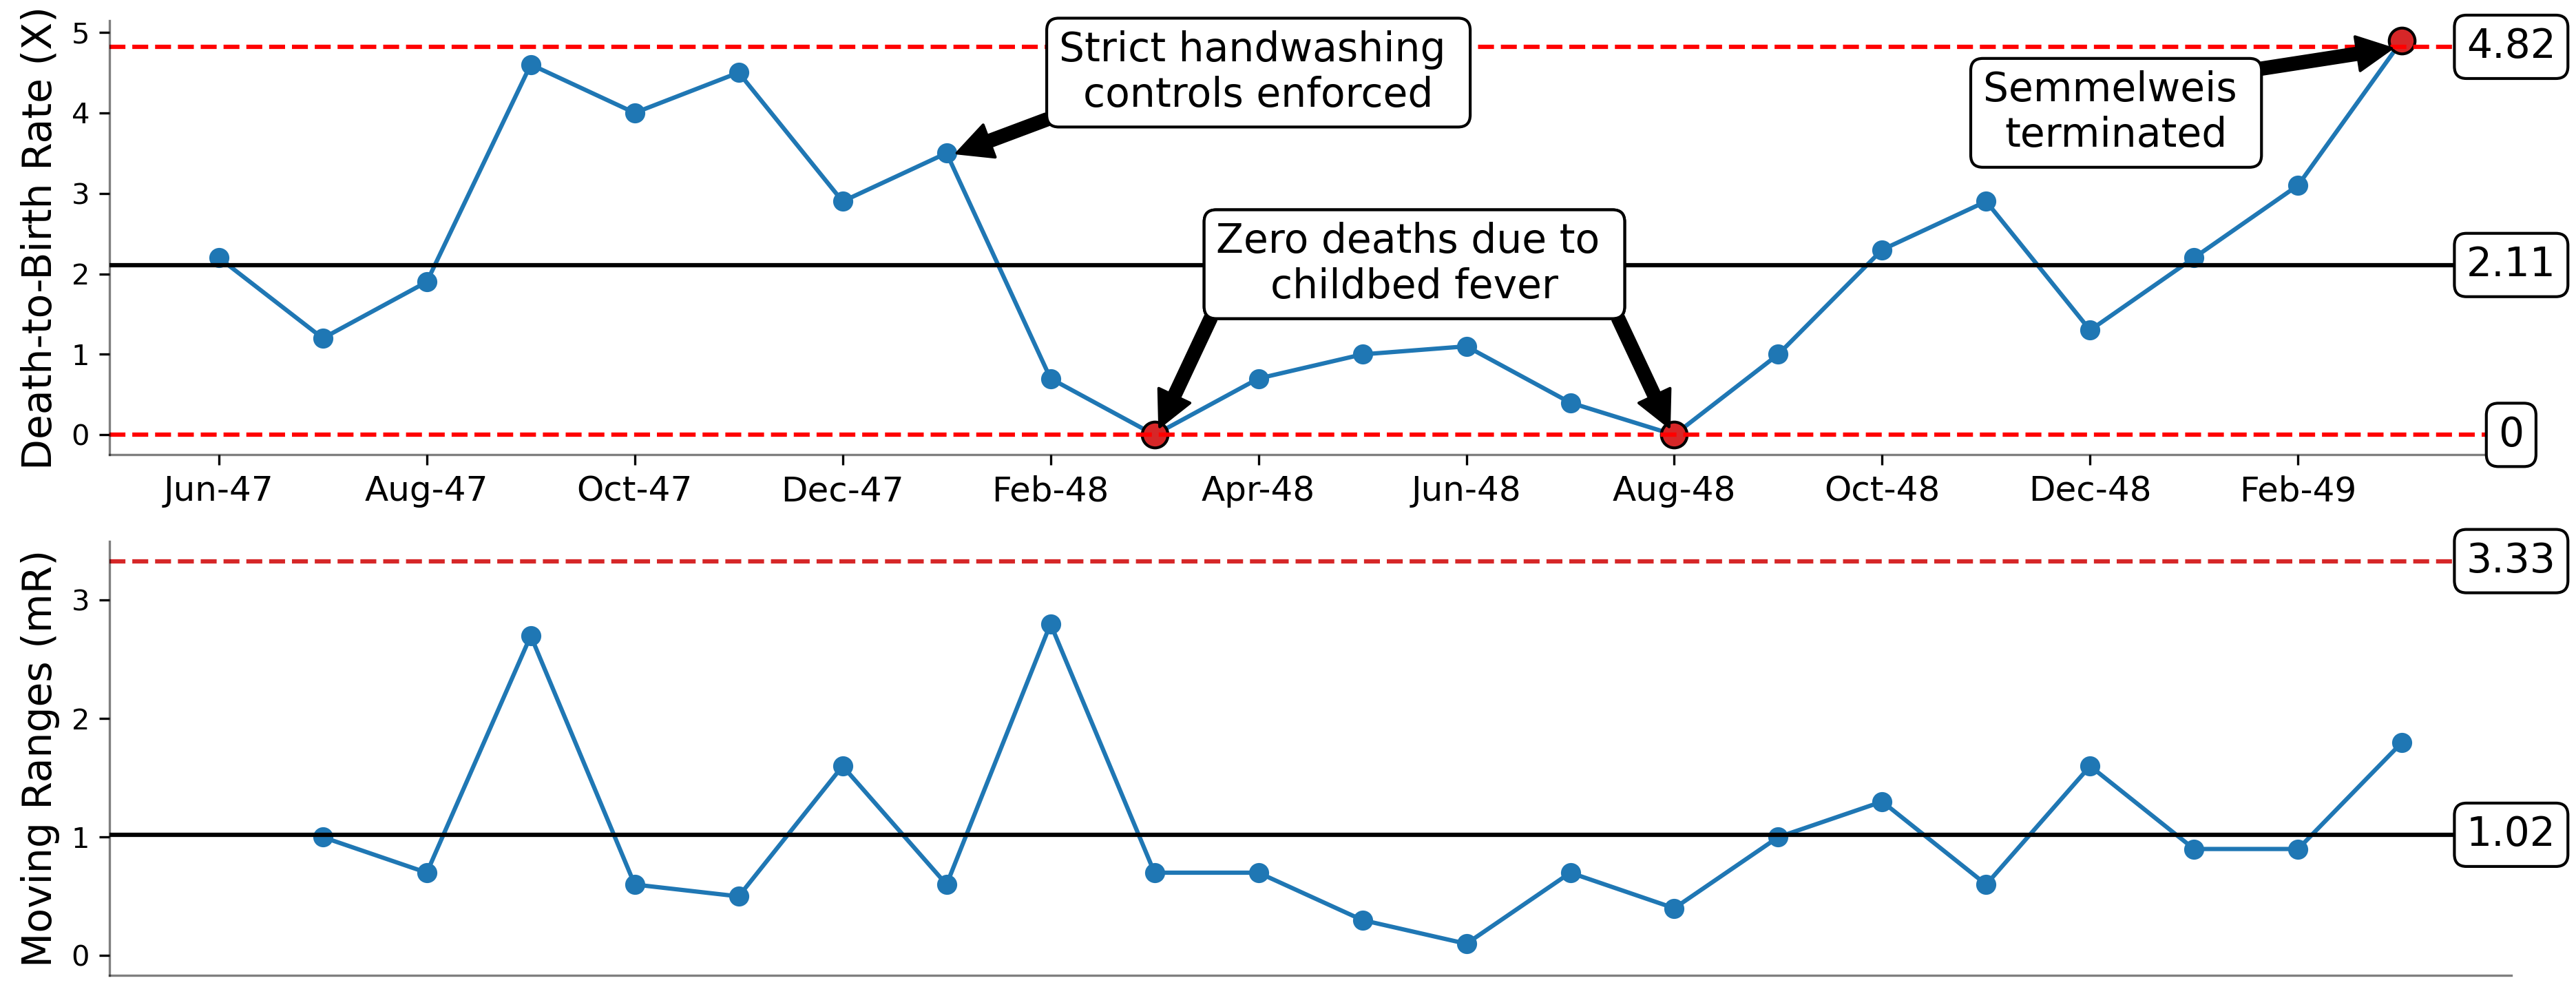

In [84]:
# Specify tickinterval
tickinterval = 2
round_value = 2

# Disaggregate the dataframe 
data = after_df["Rate"]
moving_ranges = after_df['Moving Range']
labels = after_df["MonthYear"]

C1 = 2.660
C2 = 3.268

mean = round(data.mean(),round_value)
average_mR = round(moving_ranges.mean(),2)

UPL = round(mean + (C1*average_mR),round_value)
LPL = max(0,mean - (C1*average_mR))
URL = round(C2*average_mR, 2)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean, '-', 'black'), (UPL, '--', 'red'), (LPL, '--', 'red')]
mrchart_lines = [(average_mR, '-', 'black'), (URL, '--', 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Generate the X-chart
fig, axs = plt.subplots(figsize=(15,6), nrows=2, ncols=1, dpi=300)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, UPL, color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, LPL, color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, mean, color='black', ha='center', va='center',
            fontsize=14, bbox=bbox_props)

# Add centerline and process limits 
for value, linestyle, color in xchart_lines:
    axs[0].axhline(value, ls=linestyle, c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center',
                      fontsize=12) 

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Death-to-Birth Rate (X)", fontsize=14)
axs[0].set_title("", fontsize=14)

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Strict handwashing \ncontrols enforced', (7.1,3.5),(10.,4.5)),
    ('Zero deaths due to \nchildbed fever', (9.05,0.1),(11.5,2.12)),
    ('Zero deaths due to \nchildbed fever', (13.95,0.1),(11.5,2.12)),
#     ('Semmelweis \nterminated', (20.9, 4.9),(18.15, 5.1))
    ('Semmelweis \nterminated', (20.9, 4.8),(18.25, 4.0))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black')) 
    
# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')
# Optional: highlight missing points
for xi, yi in zip(labels, moving_ranges):
    if np.isnan(yi):
        plt.plot(xi, 0, marker='x', color='white', markersize=0) 

axs[1].axhline(URL, ls='--', c='tab:red')
axs[1].axhline(average_mR, ls='-', c='black')

axs[1].text(axs[1].get_xlim()[1], URL, URL, color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], average_mR, average_mR, color='black', ha='center', va='center', 
            fontsize=14, bbox=bbox_props)

# Remove xticks on mR chart
axs[1].set_xticks([])
axs[1].set_ylabel('Moving Ranges (mR)', fontsize=14)

# Despine 
sns.despine()
for value in range(0,2):
    axs[value].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()